In [60]:
# Core functionality for managing and accessing data
from neurosynth import Dataset, decode, network
import nibabel as nib
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.io
import h5py
import glob

## Inputs

In [67]:
#choose the parc
parc = 'Sch240'
# and number of nodes to extract
n_nodes = 5
# and the mode
mode = 0

## Find rois from CCA analysis

In [69]:
# get rois of interest
docs_path = '/Users/luke/Documents/Projects/StrokeNet/Docs/'
conbound = 'conbound20/'
results_dir = docs_path + 'Results/' + conbound + parc + '/'
data = scipy.io.loadmat(results_dir + 'results.mat')
nodes = data['CCA'][0][0][14]
roi_list = np.ravel(np.vstack((nodes[0:n_nodes,0,mode],nodes[0:n_nodes,1,mode])))
print('rois include: '+str(roi_list))
len(roi_list)

rois include: [203  23  64  42  27  63  49  62  39  43  65  24  95 201  25  61  41  40
  48 204  76  22  28  99  26 205  36  60  92 100  71   6 202  47  96 206
  51  75  32  81  87   5  45  52  18  35  31  66  15  59  44  13  12  93
  74  11   4  10  86  16  77  70  21  72  98  78  79  88  69   7  30  97
  58   1  82  85  80  50  37  91  33  20   3  57  68  73 207   9  19  29
  84  67  14  17  54  38   8  34  94  83  89  90  56  53  46 195 183   2
  55 186 221 111 229 110 133 170 234 194 215 230 141 169 168 130 120 167
 210 142 126 152 146 127 143 114 185 155 176 138 180 184 209 153 118 137
 178 208 200 133 145 211 116 212 147 177 189 106 193 194 160 213 148 183
 135 132 128 158 154 166 105 175 159 101 186 129 181 149 157 187 170 111
 110 122 109 199 124 115 123 165 196 179 113 156 151 195 198 144 104 125
 150 182 131 119 108 136 192 197 103 102 139 214 134 164 107 117 173 174
 112 161 191  74 121 162 163 188 172 171 190 140  97  66 202  77 234  80
  10  52  81  82  71  32]


240

## Load the parcellation

In [70]:
# get parcellation
#load the roi-parcellation
if parc=='Sch214':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/Schaefer200/Schaefer200_plus_HO.nii'
elif parc=='BN':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/BNAtlas/BN_Atlas_246_2mm.nii'
elif parc=='Sch240':
    parcellation_file = '/Users/luke/Documents/Projects/StrokeNet/Docs/Atlas/Schaefer200/Schaefer200_plus_HOAAL.nii'
img_parc = nib.load(parcellation_file)
img_parc_data = img_parc.get_data()

## Load the neurosynth dataset and features

Features are from Poldrack et al., 2012 (https://github.com/poldrack/LatentStructure). There are ~500 unique features.

In [72]:
path_to_neurosynthdata = '/Users/luke/Documents/Projects/StrokeNet/Data/topicMapping/'

# load the pickle
dataset = Dataset.load(path_to_neurosynthdata+'dataset.pkl')

# get features - https://github.com/poldrack/LatentStructure
features_df = pd.read_csv(path_to_neurosynthdata+'Poldrack_2012_terms.csv',header=None)
features_df.replace('_', ' ', regex=True,inplace=True)
cognitive_features = features_df[0].tolist()
cognitive_features = np.unique(cognitive_features)
print('number of unique terms:'+ str(np.shape(cognitive_features)))

number of unique terms:(545,)


## Save rois as Nifti

In [65]:
for roi in roi_list:
    roi_img = np.zeros((np.shape(img_parc_data)))
    roi_img[img_parc_data==roi]=1
    roi_img = nib.Nifti1Image(roi_img,img_parc.affine)
    out_name = path_to_neurosynthdata+'roi/'+parc+'_roi_'+str(roi)+'.nii'
    nib.save(roi_img,out_name)

## Decode the rois

### Association based decoding
Not appropriate for binary rois

In [7]:
## association method
# set up the decoder
#decoder = decode.Decoder(dataset,features=cognitive_features)

#nii_list=[]
#for nii in range(n_nodes*2):
#    roi = roi_list[nii]
#    nii = parc+'_roi_'+str(roi)
#    nii_list.append('roi/'+nii+'.nii')
    
#run the decoding
#neurosynth_results = decoder.decode(nii_list, save='decoding_results_Schaefer.txt')
#neurosynth_results.head()

### Roi based decoding
from: https://groups.google.com/forum/#!searchin/neurosynthlist/method$3D$27roi$27|sort:date/neurosynthlist/7kyLBuTXUGQ/_Xrt3pF3BQAJ

*You can select that one by passing method='roi', but be aware that it won't produce meaningful results unless you have a binary mask. Basically, it does a meta-analytic comparison of all studies that activate within the passed ROI versus all the ones that don't. If your input _is_ binary, I would probably recommend using this approach rather than the pearson approach. Otherwise stick with pearson (unless you want to implement new methods, which I would certainly welcome).*

In [73]:
## roi method
# set up the decoder
decoder = decode.Decoder(dataset,method='roi')

nii_list=[]
for nii in range(n_nodes*2):
    roi = roi_list[nii]
    nii = parc+'_roi_'+str(roi)
    nii_list.append(path_to_neurosynthdata+'roi/'+nii+'.nii')
    
#run the decoding
neurosynth_results = decoder.decode(nii_list, save=path_to_neurosynthdata+'decoding_results_'+parc+'_mode'+str(mode)+'.txt')
neurosynth_results.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_230,cluster_231,cluster_232,cluster_233,cluster_234,cluster_235,cluster_236,cluster_237,cluster_238,cluster_239
001,1.0838,-1.1034,-2.8988,-0.4045,-1.8067,-2.2005,-1.4091,-0.6117,-1.6336,-1.0717,...,0.0822,-1.2508,-0.4319,-0.9344,-0.7474,0.7043,0.1373,-1.0981,-1.2466,-2.5188
01,-0.2818,-0.2889,-2.7764,-2.1161,-0.2125,-2.5369,-1.5416,-0.3786,-2.6343,-1.3390,...,-0.7651,0.8166,-0.4073,1.2696,-1.9145,2.9253,0.5136,0.8289,-1.3802,-2.3483
05,-0.5181,-0.3670,-3.4135,-1.2021,-0.3538,-4.2435,-3.3893,-2.0627,-2.6692,-1.4742,...,-1.3594,-2.0024,0.4717,-2.1610,-1.0625,2.6823,0.1275,-0.5763,-0.2369,-3.6502
10,-0.4484,-0.9470,-1.2901,1.4787,-1.1231,-1.5203,-1.6408,1.3205,-2.4073,-1.3044,...,0.5871,-0.0913,0.0785,-0.5137,-0.3443,0.2354,1.4989,0.2626,1.6925,-1.1464
100,-1.2760,2.7565,-1.5542,-0.1342,-0.2627,-0.5865,-1.7395,-1.7739,-0.0985,-2.2821,...,-0.6068,-0.1919,-1.3091,-0.7487,-0.3510,-0.1517,0.0167,-0.1064,-0.7587,-0.9192


#### trim the results to useful features

In [15]:
idx = neurosynth_results.index.isin(cognitive_features)

neurosynth_results_trimmed = neurosynth_results[idx]
neurosynth_results.to_csv(path_to_neurosynthdata+'decoding_results_'+parc+'_mode'+str(mode)+'_trimmed.txt')
neurosynth_results_trimmed.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
action,0.0342,-1.8829,8.1026,0.9354,4.5956,7.1424,0.1543,4.8810,1.9360,6.5935
adaptation,-1.4924,-0.9151,-0.8036,-1.3564,-1.9116,-1.2590,-0.8714,0.3122,-1.8216,-1.3186
anticipation,6.3779,2.4234,-1.6305,1.5285,-0.8782,-0.5475,-1.8932,-0.1213,-0.5582,2.1773
arousal,1.3010,1.2123,-1.3957,3.3515,-1.4511,-0.0154,0.1134,-1.2607,-0.8910,0.1081
association,0.5569,-0.2698,-0.2516,-0.7868,-0.4670,-1.5531,-1.3624,-2.4692,-0.0973,-0.7222


#### (alternatively) list the top 10 for each cluster
Returns mostly anatomical terms which is a pain to go through, so using the dictionary is better, I think.

In [55]:
labels = neurosynth_results.index.tolist()
number_of_terms = 9
for roi in range(np.shape(neurosynth_results)[1]):
    data = neurosynth_results.values[:,roi]
    data_sorted = np.sort(data)[::-1]
    cutoff = data_sorted[number_of_terms]
    idx = np.where(data >=cutoff)[0]
    selected_labels = []
    for i in range(len(idx)):
        selected_labels.append(labels[idx[i]])
    print(selected_labels)

['basal', 'basal ganglia', 'cortical subcortical', 'ganglia', 'motor', 'putamen', 'reward', 'striatal', 'striatum', 'ventral striatum']
['insula', 'insular', 'pain', 'posterior insula', 'primary', 'secondary somatosensory', 'sii', 'somatosensory', 'somatosensory cortex', 'stimulation']
['frontal', 'inferior', 'inferior frontal', 'phonological', 'premotor', 'reading', 'task', 'tasks', 'ventral premotor', 'word']
['insula', 'insular', 'insular cortex', 'pain', 'painful', 'posterior insula', 'secondary', 'secondary somatosensory', 'somatosensory', 'somatosensory cortex']
['motor', 'motor cortex', 'premotor', 'primary motor', 'production', 'sensorimotor', 'somatosensory', 'speech', 'speech production', 'ventral premotor']
['eye', 'eye field', 'eye fields', 'eye movements', 'fields', 'frontal eye', 'motor', 'movements', 'premotor', 'premotor cortex']
['dorsolateral', 'dorsolateral prefrontal', 'frontal', 'inferior frontal', 'prefrontal', 'prefrontal cortex', 'task', 'tasks', 'working', 'wor

#### (alternatively) apply every roi's CCA weight to their decoding-label weight
Need to run every ROI to do this

In [75]:
nodes

array([[[203,  39],
        [141, 201]],

       [[ 23,  63],
        [169, 223]],

       [[ 64,  65],
        [168, 215]],

       [[ 42,  27],
        [130, 221]],

       [[ 27,  64],
        [120, 229]],

       [[ 63,  61],
        [167, 230]],

       [[ 49,  28],
        [210,   1]],

       [[ 62,  76],
        [142, 224]],

       [[ 39,  16],
        [126, 206]],

       [[ 43,  62],
        [152,   8]],

       [[ 65,  18],
        [146,  99]],

       [[ 24,  15],
        [127, 204]],

       [[ 95,  95],
        [143,  98]],

       [[201,  48],
        [114, 227]],

       [[ 25,  36],
        [185, 219]],

       [[ 61,  60],
        [155, 205]],

       [[ 41,  32],
        [176, 228]],

       [[ 40,  43],
        [138, 240]],

       [[ 48,  40],
        [180, 220]],

       [[204, 133],
        [184,   7]],

       [[ 76,  49],
        [209, 237]],

       [[ 22, 194],
        [153, 217]],

       [[ 28,  72],
        [118, 222]],

       [[ 99,  45],
        [137, 

## Visualise the results

In [58]:
def word_brain_plot(df,nii):
    #https://github.com/amueller/word_cloud
    import matplotlib.pyplot as plt
    from nilearn import plotting
    from wordcloud import WordCloud

    def getWordFreq(df,nii):
        text = df.index.values
        freq = df[nii].values*10000
        tmpDict={}
        for i,word in enumerate(text):
            val = freq[i]
            tmpDict[word.lower()] = np.round(val)
        return tmpDict

    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(getWordFreq(df,nii))

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(fname, dpi=600)
    plt.show()
    
    # brain
    plotting.plot_stat_map(nii,threshold=0.1, title=nii)
    plotting.show()

def word_brain_plot_roi(df,nii,col,fname):
    #https://github.com/amueller/word_cloud
    import matplotlib.pyplot as plt
    from nilearn import plotting
    from wordcloud import WordCloud

    def getWordFreq(df,col):
        text = df.index.values
        freq = df[col].values*10000
        tmpDict={}
        for i,word in enumerate(text):
            val = freq[i]
            tmpDict[word.lower()] = np.round(val)
        return tmpDict

    wc = WordCloud(background_color="white", max_words=50)
    wc.generate_from_frequencies(getWordFreq(df,col))

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(fname, dpi=600)
    plt.show()

    # brain
    plotting.plot_glass_brain(nii,threshold=0.1, title=nii)
    plotting.show()

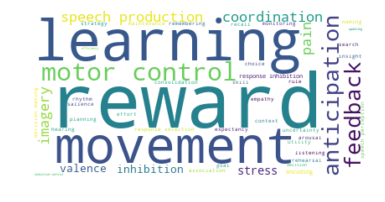

/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


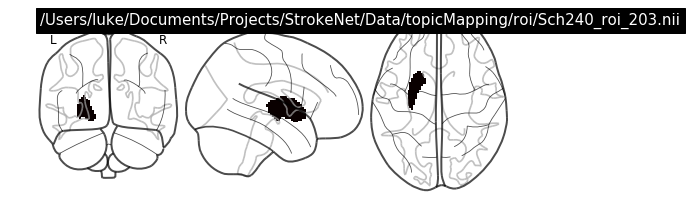

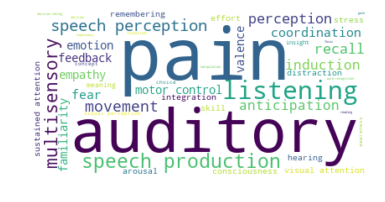

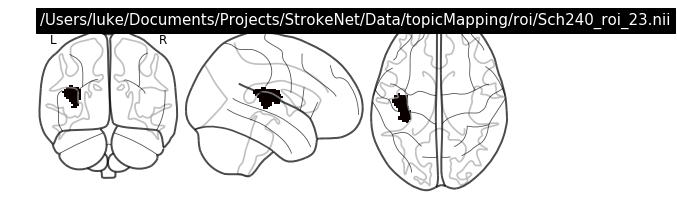

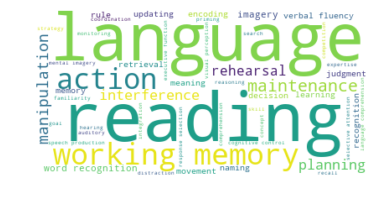

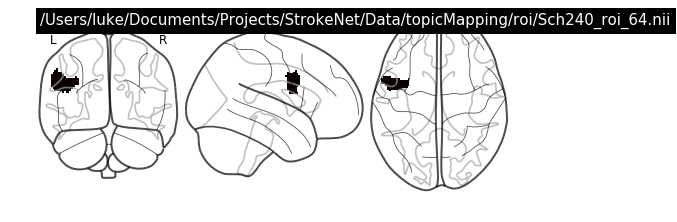

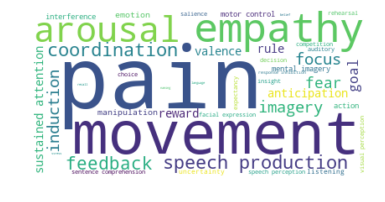

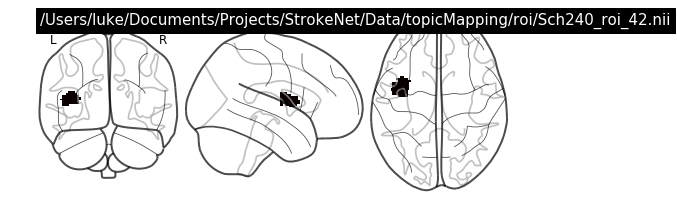

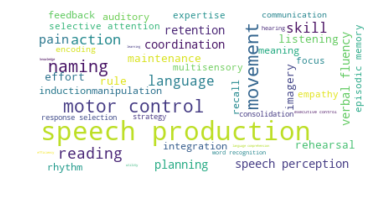

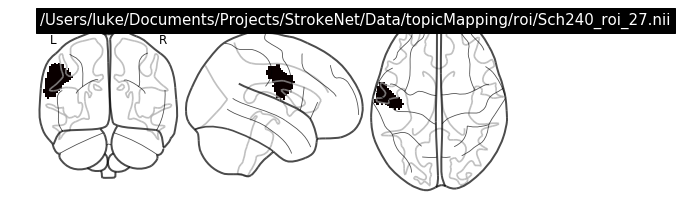

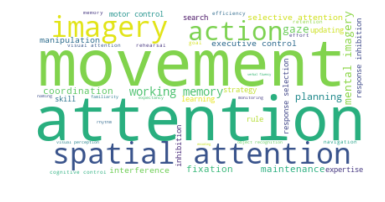

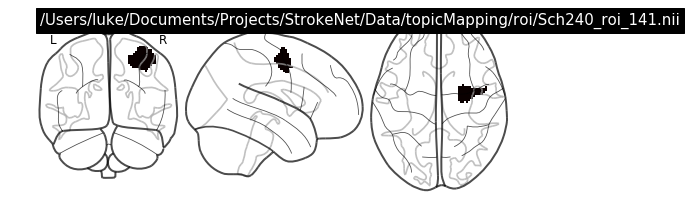

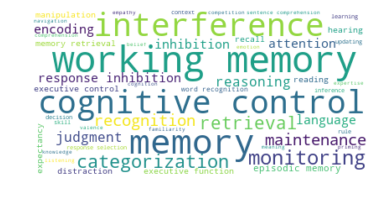

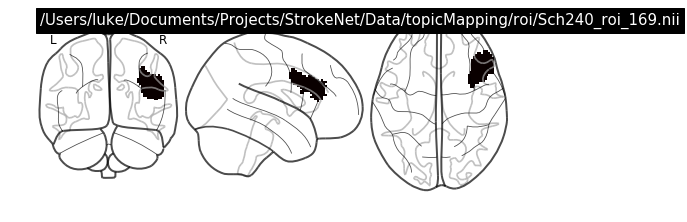

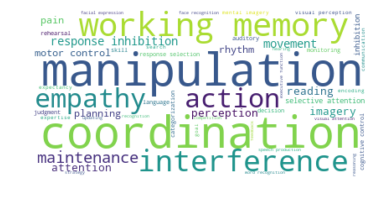

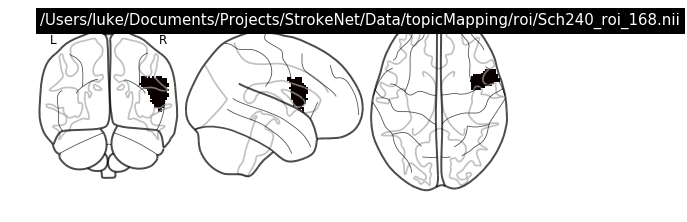

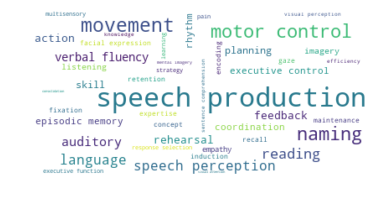

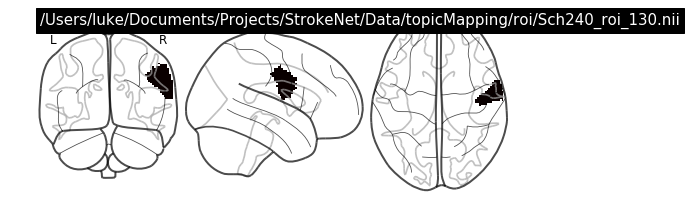

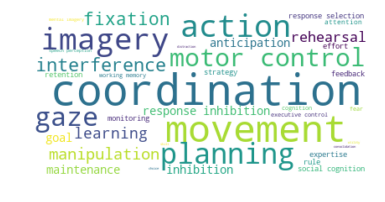

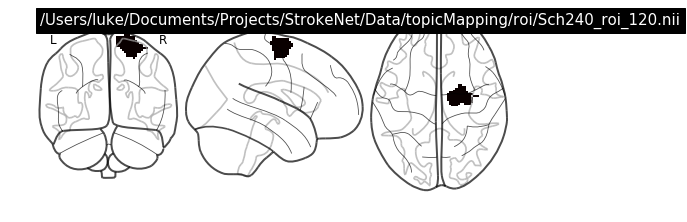

In [59]:

for i,roi in enumerate(roi_list):
    nii = nii_list[i]
    fname = path_to_neurosynthdata+'word_clouds/decoding_results_roi'+str(i)+'_'+parc+'_mode'+str(mode)+'_trimmed.jpeg'
    word_brain_plot_roi(neurosynth_results_trimmed,nii,'cluster_'+str(i),fname)

## Calculate meta-coactivation

*from: https://groups.google.com/forum/#!msg/neurosynthlist/ch-Ps5fwo00/cWWDUC4yRtoJ*

p: probability
A: activation
g: given
F: feature present
z: z-score
FDR: FDR-corrected (the value after that is the specific false positive rate used in the correction, e.g., 0.05)

Which gives us:

_pA: the probability of a study reporting activation at that voxel (i.e., the proportion of all studies in the Neurosynth database that report activation). This is just a base rate map so you can get a sense of how activation is distributed around the brain (without any consideration for the particular terms you're using in the meta-analysis).

_pAgF: the probability of activation given that a study is tagged with the feature (in your case, whatever Social Perception is). This is what I refer to as forward inference on the website and in the paper.

_pAgF_given_pF=0.5: same as above, but with a uniform prior imposed (i.e., we pretend there is an equal probability of a study being in the SocialPerception set or not being in the SocialPerception set). This is important as it allows you to compare different features (otherwise the results are dominated by the empirical prior).

_pAgF_z: z-score map corresponding to the _pAgF map. I.e., where the _pAgF map gives you the point estimate of effect size, the _z map gives you the a sense of the confidence in the inference that a voxel is or is not consistently activated for (in this case) SocialPerception studies.

_pAgF_z_FDR* : self-explanatory.

_pFgA, _pFgA_given_pF=0.5, etc.: These are all the same as the pAgF maps, except they're what we refer to as reverse inference rather than forward inference. In other words, they're telling you about the probability that a study in the database is tagged with a particular feature given that activation is present at a particular voxel. So whereas the pAgF maps are maps of consistency (roughly, if someone reports a SocialPerception study, where is activation likely to be reported), the pFgA are maps of specificity (i.e., if you see activation at a particular voxel, how much more likely is a study to be associated with SocialPerception than not).